# Predict the speed of Pet Adoption

The goal of the project is to build a product that would predict the speed at which a pet would be adopted, given the description of the pet. The most interesting thing about the project is the dataset - it contains both, structured and unstructred dataset, i.e. tabular as well image data. The dataset is intuitive with respect to the problem and at the same time quite challenging.[](http://) 

# An overview of the dataset

The dataset used is an open-source dataset of kaggle. The following gives an overview of the data fields representing a pet 

PetID - Unique hash ID of pet profile <br>
AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict <br> 
**Type - Type of animal (1 = Dog, 2 = Cat)** <br>
Name - Name of pet (Empty if not named) <br>
Age - Age of pet when listed, in months <br>
Breed1 - Primary breed of pet (Refer to BreedLabels dictionary) <br>
Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary) <br>
Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets) <br>
Color1 - Color 1 of pet (Refer to ColorLabels dictionary) <br>
Color2 - Color 2 of pet (Refer to ColorLabels dictionary) <br>
Color3 - Color 3 of pet (Refer to ColorLabels dictionary) <br>
MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified) <br>
FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified) <br>
Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure) <br>
Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure) <br>
Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure) <br>
Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified) <br>
Quantity - Number of pets represented in profile <br>
Fee - Adoption fee (0 = Free) <br>
State - State location in Malaysia (Refer to StateLabels dictionary) <br>
RescuerID - Unique hash ID of rescuer <br>
VideoAmt - Total uploaded videos for this pet <br>
PhotoAmt - Total uploaded photos for this pet <br>

In [46]:
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import stats
import cv2
from keras.utils import Sequence

# 1. Load Data

The ETL process is performed locally. The data is extracted from the csv and jpg files. The transformed tabular and image data are stored in a dataframe, numpy files respectively, which are then used for modelling

### 1.1 Training Data 
Tabular/text data for the training set

In [2]:
#load and display the 1st 10 rows of the train data
df = pd.read_csv("../input/training/input.csv", index_col=0)
df.head(5)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2


In [3]:
# dataset dimension
n_rows = df.shape[0]
n_cols = df.shape[1]

print("\nNumber of rows - ", n_rows, "\nNumber of columns - ", n_cols)

# dataset datatypes - #int cols, #string cols
# would be useful during one-hot encoding
n_stringTypes = 0 

for i in df.iloc[0]:
    if type(i)==str:
        n_stringTypes+=1
print("Number of string type columns - ", n_stringTypes) 


Number of rows -  14993 
Number of columns -  23
Number of string type columns -  3


### 1.2 Breed Labels [Part of training data]
Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.

In [4]:
filepath = '../input/petfinder-adoption-prediction/PetFinder-BreedLabels.csv'
df_breedLabels = pd.read_csv(filepath)
df_breedLabels.head(5)

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [5]:
# dataset dim
n_df_breedRows = df_breedLabels.shape[0]
n_df_breedCols = df_breedLabels.shape[1]
print("Dataset shape - ", df_breedLabels.shape)
# different number of breeds for dog [type=1] and cat [type=2]

grp1, grp2 = df_breedLabels.groupby('Type').apply(lambda ser: ser['BreedName'].unique())
print("\nDog Breeds - ", grp1[:10], "....","\nNumber of Dog Breeds - ", len(grp1))
print("\nCat Breeds - ", grp2[:10], "....","\nNumber of Cat Breeds - ", len(grp2))

Dataset shape -  (307, 3)

Dog Breeds -  ['Affenpinscher' 'Afghan Hound' 'Airedale Terrier' 'Akbash' 'Akita'
 'Alaskan Malamute' 'American Bulldog' 'American Eskimo Dog'
 'American Hairless Terrier' 'American Staffordshire Terrier'] .... 
Number of Dog Breeds -  241

Cat Breeds -  ['Abyssinian' 'American Curl' 'American Shorthair' 'American Wirehair'
 'Applehead Siamese' 'Balinese' 'Bengal' 'Birman' 'Bobtail' 'Bombay'] .... 
Number of Cat Breeds -  66


### 1.3 Color Labels [Part of training data] 
 Contains ColorName for each ColorID

In [6]:
filepath = '../input/petfinder-adoption-prediction/PetFinder-ColorLabels.csv'
df_ColorLabels = pd.read_csv(filepath)
print(df_ColorLabels)
print("Shape - ", df_ColorLabels.shape)
print("Number of unique color for pet dataset - ", len(df_ColorLabels))

   ColorID ColorName
0        1     Black
1        2     Brown
2        3    Golden
3        4    Yellow
4        5     Cream
5        6      Gray
6        7     White
Shape -  (7, 2)
Number of unique color for pet dataset -  7


### 1.4 State Labels [Part of Training Data]
Contains StateName for each StateID

In [7]:
filepath = '../input/petfinder-adoption-prediction/PetFinder-StateLabels.csv'
df_StateLabels = pd.read_csv(filepath)
print(df_StateLabels)
print("Shape - ", df_StateLabels.shape)
print("Number of unique states for pet dataset - ", len(df_StateLabels))

    StateID        StateName
0     41336            Johor
1     41325            Kedah
2     41367         Kelantan
3     41401     Kuala Lumpur
4     41415           Labuan
5     41324           Melaka
6     41332  Negeri Sembilan
7     41335           Pahang
8     41330            Perak
9     41380           Perlis
10    41327     Pulau Pinang
11    41345            Sabah
12    41342          Sarawak
13    41326         Selangor
14    41361       Terengganu
Shape -  (15, 2)
Number of unique states for pet dataset -  15


### 1.5 Loading Pet Image Data

The tabular data (training) is loaded in a dataframe above. Now, let's load some image data corresponding to the tabular data. Each row in the dataframe has a PetID value. The images are stored with PetID as the filename - format: <PetID>-<Integer> . The integer represent which #image is of that PetID. Default image of the pet is the one labelled 1. 


Name -  Nibble 
PetID -  86e1089a3

Data type -  uint8 
Data shape -  (480, 360, 3)


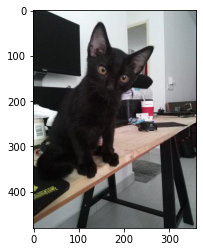


Name -  No Name Yet 
PetID -  6296e909a

Data type -  uint8 
Data shape -  (377, 399, 3)


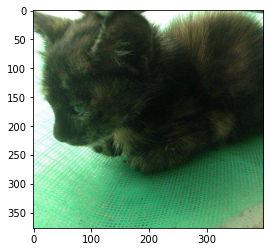

In [8]:
# Loading pet images corresponding to top 3 rows of the dataframe. This is just for visualization
# Not loading all images at once, as it would take up a lot of memory
def plot_image(filename):
    data = image.imread(filename)
    print("\nData type - ",data.dtype, "\nData shape - ", data.shape)
    # display image
    plt.imshow(data)
    plt.show()
    
img_path = "../input/petfinder-adoption-prediction/train_images/"
dff = df.head(2)
for i in range(0,len(dff)):
    print("\nName - ", dff.loc[i,'Name'], "\nPetID - ",dff.loc[i,'PetID'])
    plot_image(img_path+dff.loc[i,'PetID']+'-'+'1.jpg')
    

# 2. Data Quality Assessment - Exploring the Data
Let's conduct some quality assessment on the data obtained. Based on the assessments the data would be accordingly cleaned and transformed (if required)

#### CHECK FOR MISSING VALUES AND DUPLICATES
For duplicates, we don't need to search every column. Need to check only those columns which shouldn't semantically contain duplicate value, i.e. PetID

In [9]:
df.loc[:,'PetID'].duplicated().any() #if False, no duplicate values present

False

In [10]:
def checkIfNull():
    for i in df.columns:
        if df[i].isnull().any():
            print('Column','"',i,'"',' has missing values')
        else:
            continue
checkIfNull()

Column " Name "  has missing values


In [11]:
#Let's print the column Names
names = df.loc[:,'Name']
names[:28]
# The NaN values are visible

0                                Nibble
1                           No Name Yet
2                                Brisco
3                                  Miko
4                                Hunter
5                                   NaN
6                                 BULAT
7               Siu Pak & Her 6 Puppies
8                                   NaN
9                                 Kitty
10                                 Bear
11                                 Kali
12                               Peanut
13              2 Mths Old Cute Kitties
14                             Lost Dog
15                                  Max
16                              Brownie
17                              Blackie
18                               Beauty
19                                  NaN
20                               Godiva
21                               Tigers
22    Kenit, Kenot, Techit, Keyad, Owen
23                                Donut
24                              Cikenet


Filling the missing values - The best way to fill the missing names is to name the pet - 'No Name' (or unknown). Some pets are assigned 'No Name yet' and some 'No Name'. It would be easier to one-hot encode the names if all these no name pets are given a single name (eg. unknown)

In [12]:
df.loc[:,'Name'] = df.loc[:,'Name'].fillna('Unknown')
for i,name in enumerate(names):
    if re.search("Name", name):
        df.loc[:,'Name'][i] = "Unknown"
print(df.loc[:,'Name'][:15])
print(df.loc[:,'Name'].isnull().any())

0                      Nibble
1                     Unknown
2                      Brisco
3                        Miko
4                      Hunter
5                     Unknown
6                       BULAT
7     Siu Pak & Her 6 Puppies
8                     Unknown
9                       Kitty
10                       Bear
11                       Kali
12                     Peanut
13    2 Mths Old Cute Kitties
14                   Lost Dog
Name: Name, dtype: object
False


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### DATA TYPE CHECK
Check if data types of col match their content

In [13]:
dtypes = {}
for i,k in enumerate(df.iloc[0]):
    dtypes[df.columns[i]] = type(k)
print(dtypes)
# from the output it can be stated that the data types of each col match their content

{'Type': <class 'numpy.int64'>, 'Name': <class 'str'>, 'Age': <class 'numpy.int64'>, 'Breed1': <class 'numpy.int64'>, 'Breed2': <class 'numpy.int64'>, 'Gender': <class 'numpy.int64'>, 'Color1': <class 'numpy.int64'>, 'Color2': <class 'numpy.int64'>, 'Color3': <class 'numpy.int64'>, 'MaturitySize': <class 'numpy.int64'>, 'FurLength': <class 'numpy.int64'>, 'Vaccinated': <class 'numpy.int64'>, 'Dewormed': <class 'numpy.int64'>, 'Sterilized': <class 'numpy.int64'>, 'Health': <class 'numpy.int64'>, 'Quantity': <class 'numpy.int64'>, 'Fee': <class 'numpy.int64'>, 'State': <class 'numpy.int64'>, 'RescuerID': <class 'str'>, 'VideoAmt': <class 'numpy.int64'>, 'PetID': <class 'str'>, 'PhotoAmt': <class 'numpy.float64'>, 'AdoptionSpeed': <class 'numpy.int64'>}


#### SET AND FOREIGN KEY MEMBERSHIP
Set Membership -> Check if only allowed values are chosen for categorical fields.<br>
FK Membership -> Check if only allowed values (with respect to the reference table values) are present in a field

In [14]:
#Set Membership 

# Gender
print('Gender - ', df.loc[:,'Gender'].isin([1,2,3]).all())
#Fur length
print('Fur length - ', df.loc[:,'FurLength'].isin([0,1,2,3]).all())
# MaturitySize
print('Maturity - ', df.loc[:,'MaturitySize'].isin([0,1,2,4,3]).all())
# Vaccinated
print('Vaccinated - ', df.loc[:,'Vaccinated'].isin([1,2,3]).all())
# Dewormed
print('Dewormed - ', df.loc[:,'Dewormed'].isin([1,2,3]).all())
# Sterilized
print('Sterilized - ', df.loc[:,'Sterilized'].isin([1,2,3]).all())
# Health
print('Health - ', df.loc[:,'Health'].isin([0,1,2,3]).all())

Gender -  True
Fur length -  True
Maturity -  True
Vaccinated -  True
Dewormed -  True
Sterilized -  True
Health -  True


In [15]:
# Foreign Key membership - Breed, color, state

#breed
print('Breed 1 - ', df.loc[:,'Breed1'].isin(df_breedLabels.loc[:,'BreedID']).all())
print('Breed 2 - ', df.loc[:,'Breed2'].isin(df_breedLabels.loc[:,'BreedID']).all())

#color
print('Color 1 - ', df.loc[:,'Color1'].isin(df_ColorLabels.loc[:,'ColorID']).all())
print('Color 2 - ', df.loc[:,'Color2'].isin(df_ColorLabels.loc[:,'ColorID']).all())
print('Color 3 - ', df.loc[:,'Color3'].isin(df_ColorLabels.loc[:,'ColorID']).all())

#State
print('State - ', df.loc[:,'State'].isin(df_StateLabels.loc[:,'StateID']).all())

Breed 1 -  False
Breed 2 -  False
Color 1 -  True
Color 2 -  False
Color 3 -  False
State -  True


In [16]:
#Cols - Breed1, Breed2, Color2, Color3 needs to be checked
def getIndices(col,colname):
    indices = col[col==False].index[:]
    ls = [df.loc[i,colname] for i in indices]
    return ls, indices
        
breed1 = df.loc[:,'Breed1'].isin(df_breedLabels.loc[:,'BreedID'])
breed2 = df.loc[:,'Breed2'].isin(df_breedLabels.loc[:,'BreedID'])
color2 = df.loc[:,'Color2'].isin(df_ColorLabels.loc[:,'ColorID'])
color3 = df.loc[:,'Color3'].isin(df_ColorLabels.loc[:,'ColorID'])

b1,ind = getIndices(breed1, 'Breed1')
b2,ind2 = getIndices(breed2, 'Breed2')
c2,ind3 = getIndices(color2, 'Color2')
c3,ind4 = getIndices(color3, 'Color3')
print('\nb1 values (anomaly) -', b1,' at indices', ind,'\nb2 no of anomalous values - ',len(ind2))
print('c2 no of anomalous values - ', len(ind3), '\nc3 no of anomalous values - ', len(ind4))


b1 values (anomaly) - [0, 0, 0, 0, 0]  at indices Int64Index([391, 1045, 3219, 7285, 7706], dtype='int64') 
b2 no of anomalous values -  10762
c2 no of anomalous values -  4471 
c3 no of anomalous values -  10604


Since the no of samples having values different from the allowed values (wrt reference table) is quite large, removing these samples/rows just based on these 3 attributes would reduce a significant chunk of data. And filling these col values would only make these samples spurious. So,let's keep it as it is - and treat these values as breed/color unknown.
Moreover, as the number of values having other than allowed values in b2 and c3 is near to the total no of samples, these columns won't contribute much to training. Hence, can be dropped

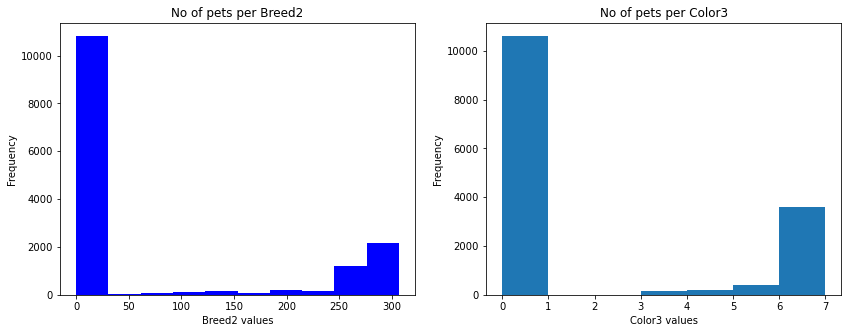

In [17]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].hist(df.loc[:,'Breed2'], color='blue')
axes[0].set_xlabel('Breed2 values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('No of pets per Breed2')

axes[1].hist(df.loc[:,'Color3'], bins = df_ColorLabels.shape[0],histtype='barstacked')
axes[1].set_xlabel('Color3 values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('No of pets per Color3')
plt.show()

# 3. Feature Engineering
Feature selection, feature extraction, Normalization, ...

From above plots, it is clear that most of the values in Breed2 and Color3 are 0, i.e. unknown, and as such do not provide any significant information in the prediction of the adoption speed. 
Thus, manually these features can be removed

In [18]:
# Dropping the Breed2 and Color3 columns
df = df.drop(['Breed2', 'Color3'], axis=1)
df.head(5)

,Type,Name,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,...,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,1,1,7,1,1,2,...,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2
1,2,Unknown,1,265,1,1,2,2,2,3,...,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0
2,1,Brisco,1,307,1,2,7,2,2,1,...,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3
3,1,Miko,4,307,2,1,2,2,1,1,...,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2
4,1,Hunter,1,307,1,1,0,2,1,2,...,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2


Let's check how data is distributed in other categorical columns, especially those having more than 3 unique values (assumed - data would be approx uniformly distributed when no of bins are less)

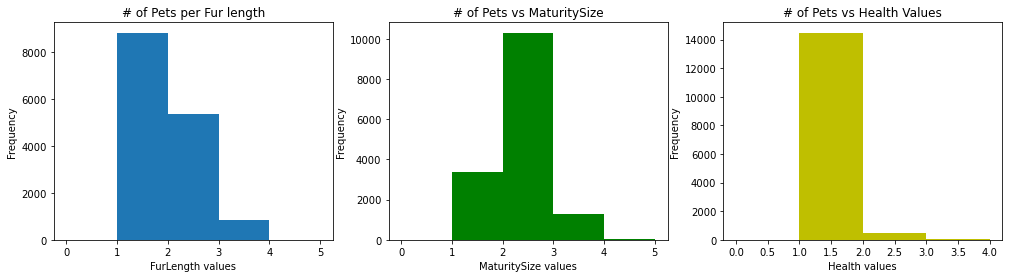

In [19]:
fig, axes = plt.subplots(1,3, figsize=(17,4))

axes[0].hist(df.loc[:,'FurLength'], bins = range(0,6,1))
axes[0].set_xlabel('FurLength values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('# of Pets per Fur length')

axes[1].hist(df.loc[:,'MaturitySize'], bins = range(0,6,1),color='g')
axes[1].set_xlabel('MaturitySize values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('# of Pets vs MaturitySize')

axes[2].hist(df.loc[:,'Health'], bins = range(0,5,1),color='y')
axes[2].set_xlabel('Health values')
axes[2].set_ylabel('Frequency')
axes[2].set_title('# of Pets vs Health Values')

plt.show()

#### DATA DISTRIBUTION IN COLUMNS - MIN-MAX VALUES, OVERALL STATS
How are the values distributed in each data columns? Let's perform some statistical analysis

In [20]:
# non-categorical attributes - Age, Quantity,Fee,VideoAmt,PhotoAmt. Calculating range of values

age_min = df.loc[:,'Age'].min() #age is in months
age_max = df.loc[:,'Age'].max()
print("Pet ages range - ", age_max-age_min, "(max -", age_max,",min - ", age_min,")")
print("Average age of pets - ", df.loc[:,'Age'].mean())

quantity_min = df.loc[:,'Quantity'].min()
quantity_max = df.loc[:,'Quantity'].max()
print("\nMin and Max no. pets in a profile - ", quantity_min,",",quantity_max)

fee_min = df.loc[:,'Fee'].min()
fee_max = df.loc[:,'Fee'].max()
print("\nMin and Max fee - ", fee_min,",",fee_max)
print("Average adoption fee of pets - ", df.loc[:,'Fee'].mean())

video_avg = df.loc[:,'VideoAmt'].mean()
print("\nMean no of videos uploaded for each pet - ", video_avg)

photo_avg = df.loc[:,'PhotoAmt'].mean()
print("Mean no of photos uploaded for each pet - ", photo_avg)

Pet ages range -  255 (max - 255 ,min -  0 )
Average age of pets -  10.452077636230241

Min and Max no. pets in a profile -  1 , 20

Min and Max fee -  0 , 3000
Average adoption fee of pets -  21.259987994397385

Mean no of videos uploaded for each pet -  0.05675982124991663
Mean no of photos uploaded for each pet -  3.889214966984593


From the above results, the average age (in months) of pets is very near to the min age and much farther than the max age of pets. 
Similarly, the average adoption fee is nearer to the min adoption fee. 

There is a possibility of outliers being present in both the cases. A few visualizations should help clear the air.

Mean no. of videos is ~ 0. As such, this value won't seem to contribute much to training. And hence can be dropped. 

In [21]:
#AdoptionSpeed vs Distribution of VideoAmt, PhotoAmt
def adoptionSpeedDistribution():
    adoption0 = np.where(df.loc[:,'AdoptionSpeed']==0)
    adoption1 = np.where(df.loc[:,'AdoptionSpeed']==1)
    adoption2 = np.where(df.loc[:,'AdoptionSpeed']==2)
    adoption3 = np.where(df.loc[:,'AdoptionSpeed']==3)
    adoption4 = np.where(df.loc[:,'AdoptionSpeed']==4)
    adoption_ = [adoption0, adoption1, adoption2, adoption3, adoption4]
    return adoption_  

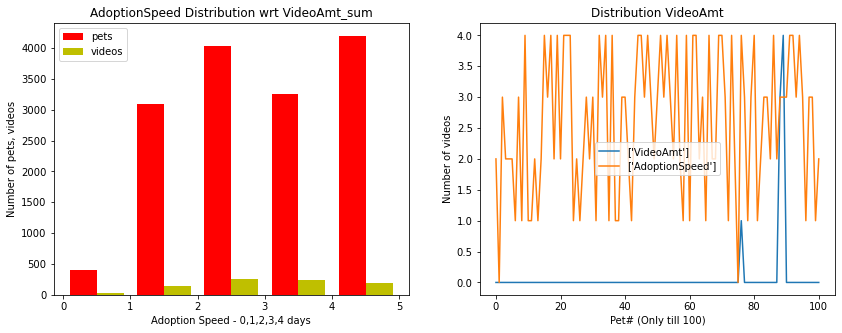

In [22]:
adoption_ = adoptionSpeedDistribution()
n_pets = []
video_amt = []
for i in range(5):
    n_pets += [i]* len(adoption_[i][0])
    video_amt += [i]* df.loc[adoption_[i][0],'VideoAmt'].sum()

fig, axes = plt.subplots(1,2, figsize=(14,5))

#Mean is not plotted for videoAmt, instead the sum is plotted, since the mean is 0 at every adoptionSpeed 
#target. Plotting the sum (which too is less as can be seen in the graph) clearly shows that VideoAmt has 
# 0 or very less impact on the target

axes[0].hist([n_pets,video_amt],bins = range(0,6,1), color = ['r','y'], label=['pets', 'videos'])
axes[1].plot(range(0,101),df.loc[:100, 'VideoAmt'], label=['VideoAmt'])
axes[1].plot(range(0,101),df.loc[:100, 'AdoptionSpeed'], label=['AdoptionSpeed'])

axes[0].set_xlabel('Adoption Speed - 0,1,2,3,4 days')
axes[0].set_ylabel('Number of pets, videos')

axes[1].set_xlabel('Pet# (Only till 100)')
axes[1].set_ylabel('Number of videos')
axes[1].legend()
axes[0].legend()
axes[0].set_title('AdoptionSpeed Distribution wrt VideoAmt_sum')
axes[1].set_title('Distribution VideoAmt')
plt.show()

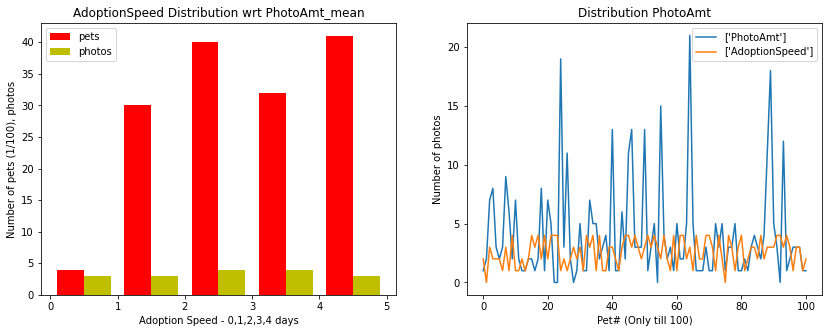

In [23]:
adoption_p = adoptionSpeedDistribution()
n_pets_ = []
photo_amt = []
for i in range(5):
    n_pets_ += [i]* int(len(adoption_p[i][0])/100)
    photo_amt += [i]* int(df.loc[adoption_p[i][0],'PhotoAmt'].astype('int64').mean())

fig, axes = plt.subplots(1,2, figsize=(14,5))

axes[0].hist([n_pets_,photo_amt],bins = range(0,6,1), color = ['r','y'], label=['pets', 'photos'])
axes[1].plot(range(0,101),df.loc[:100, 'PhotoAmt'], label=['PhotoAmt'])
axes[1].plot(range(0,101),df.loc[:100, 'AdoptionSpeed'], label=['AdoptionSpeed'])

axes[0].set_xlabel('Adoption Speed - 0,1,2,3,4 days')
axes[0].set_ylabel('Number of pets (1/100), photos')

axes[1].set_xlabel('Pet# (Only till 100)')
axes[1].set_ylabel('Number of photos')
axes[1].legend()
axes[0].legend()
axes[0].set_title('AdoptionSpeed Distribution wrt PhotoAmt_mean')
axes[1].set_title('Distribution PhotoAmt')
plt.show()

From the plots, the video amount (sum) at every target is very less to cause any impact on the adoption speed. The video amount is plotted as a sum at every bin. The 2nd graph of VideoAmt shows an almost flat curve wrt AdoptionSpeed. However, it is different for PhotoAmt. Hence, VideoAmt can conclusively be dropped off

In [24]:
df = df.drop(['VideoAmt'], axis=1)
df.shape

(14993, 20)

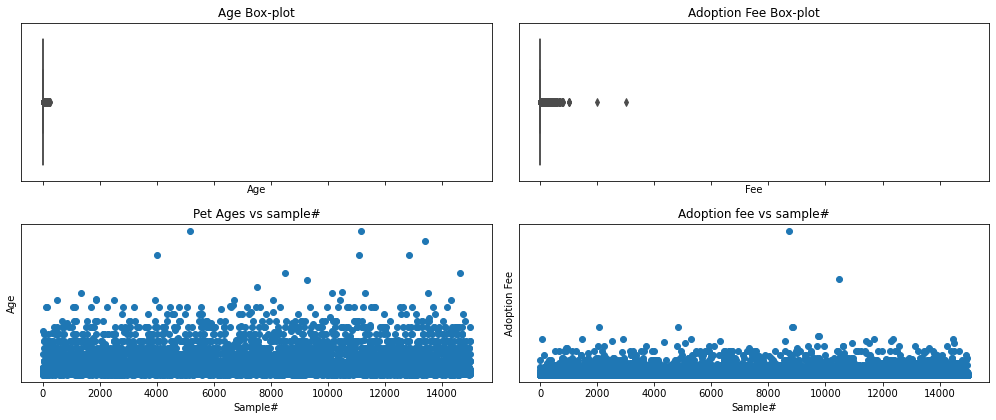

In [25]:
# box-plot for Age and adoption price - to check for outliers
fig, axes = plt.subplots(2,2,figsize=(14,6), sharex=True)

sns.set(style="whitegrid")
sns.boxplot(x=df.loc[:,'Age'], ax = axes[0,0])
axes[0,0].set_title('Age Box-plot')

sns.boxplot(x=df.loc[:,'Fee'], ax = axes[0,1])
axes[0,1].set_title('Adoption Fee Box-plot')

axes[1,0].scatter(range(0,14993), df.loc[:,'Age'])
axes[1,0].set_xlabel('Sample#')
axes[1,0].set_ylabel('Age')
axes[1,0].set_title('Pet Ages vs sample#')

axes[1,1].scatter(range(0,14993), df.loc[:,'Fee'])
axes[1,1].set_xlabel('Sample#')
axes[1,1].set_ylabel('Adoption Fee')
axes[1,1].set_title('Adoption fee vs sample#')
plt.setp(axes, yticks=[])
plt.tight_layout()


As can be seen from the plots, both 'Age' and 'Fee' have certain outliers.Let's keep the outliers for now (as no upper bound/limits mentioned for these 2 categories)

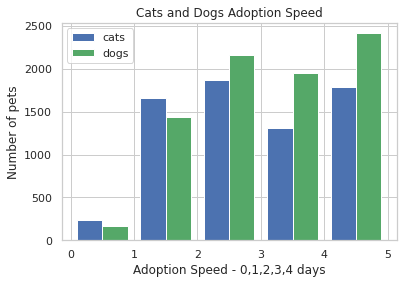

In [26]:
# Checking adoption speed of cats vs dogs

adoption_ = adoptionSpeedDistribution()
cats = []
dogs = []
for i in range(len(adoption_)):
    cats += [i]*(np.where(df.loc[adoption_[i][0],'Type']==2)[0].shape[0])
    dogs += [i]*(np.where(df.loc[adoption_[i][0],'Type']==1)[0].shape[0])

fig, axes = plt.subplots()
plt.hist([cats,dogs],bins = range(0,6,1), color = ['b','g'], label=['cats', 'dogs'])
plt.xlabel('Adoption Speed - 0,1,2,3,4 days')
plt.ylabel('Number of pets')
plt.legend()
plt.title('Cats and Dogs Adoption Speed')
plt.show()

The adoption speed for both cats and dogs are pretty much comparable. 

#### LABEL ENCODING CATEGORICAL (STRING TYPE) ATTRIBUTES, SCALING ATTRIBUTE VALUES

In [27]:
# Label Encoding 'Name', 'RescuerID', 'State'
def labelEncode(attr):
    enc = LabelEncoder()
    attr_ = list(attr)
    enc.fit(attr_)
    return enc.transform(attr_)

#Not encoding PetID, since it represents the image, which would be seperated out as a different dataset
df.loc[:,'Name'] = labelEncode(df.loc[:,'Name'])
df.loc[:,'RescuerID'] = labelEncode(df.loc[:,'RescuerID'])
df.loc[:,'State'] = labelEncode(df.loc[:,'State'].astype(str))
df.head(5)

,Type,Name,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,PetID,PhotoAmt,AdoptionSpeed
0,2,5950,3,299,1,1,7,1,1,2,2,2,1,1,100,2,2932,86e1089a3,1.0,2
1,2,8369,1,265,1,1,2,2,2,3,3,3,1,1,0,12,1113,6296e909a,2.0,0
2,1,1488,1,307,1,2,7,2,2,1,1,2,1,1,0,2,5485,3422e4906,7.0,3
3,1,5391,4,307,2,1,2,2,1,1,1,2,1,1,150,12,3232,5842f1ff5,8.0,2
4,1,3678,1,307,1,1,0,2,1,2,2,2,1,1,0,2,3297,850a43f90,3.0,2


In [28]:
df.loc[:,'State'].max() #number of unique state values

13

The values corresponding to Name, RescuerID, Breed1 attributes are quite large. Feeding these values would result in an uneven model training. Need to check out their distribution, if some values can be removed. 

However, before scaling the values of these columns, let's first check whether these attributes are really important for training the model. 

#### FEATURE SELECTION - IMPACT OF AN ATTRIBUTE IN DETERMINING THE TARGET

In [29]:
# Correlation matrix of the dataset

corr = df.corr(method='pearson')
adoptionSpeed = corr['AdoptionSpeed'][:-1]
#correlation of attributes with adoptionspeed
adoptionSpeed

Type           -0.091240
Name            0.011689
Age             0.100510
Breed1          0.107834
Gender          0.057622
Color1         -0.044192
Color2         -0.038579
MaturitySize    0.045653
FurLength      -0.091337
Vaccinated     -0.059043
Dewormed       -0.013210
Sterilized     -0.083447
Health          0.029382
Quantity        0.062931
Fee            -0.004017
State           0.015954
RescuerID      -0.002995
PhotoAmt       -0.023233
Name: AdoptionSpeed, dtype: float64

Instead of having any threshold for correlation values (as most of the values are in similar range) to eliminate certain attribute, let's simply eliminate the least correlated attribute (1 +ve corr, -1 -ve corr, 0 no corr)

In [30]:
x = np.where(adoptionSpeed<0)
col = adoptionSpeed[x[0]].idxmax() #column to delete
col

'RescuerID'

In [31]:
df = df.drop(['RescuerID'],axis=1)
df.shape

(14993, 19)

In [32]:
#correlation matrix
corr

,Type,Name,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,PhotoAmt,AdoptionSpeed
Type,1.000000,0.038793,-0.147162,0.057724,0.060843,0.097680,0.246333,-0.171811,0.003036,0.102907,0.025508,0.006737,-0.006864,0.036423,-0.042134,0.120329,-0.101140,0.049368,-0.091240
Name,0.038793,1.000000,-0.000658,0.005592,0.002422,0.052772,0.014380,-0.031980,-0.008090,0.038776,0.043751,0.028798,0.014251,0.002285,-0.005807,0.033081,-0.026571,-0.044393,0.011689
Age,-0.147162,-0.000658,1.000000,-0.314346,-0.123423,0.090378,-0.039427,0.093673,0.153092,-0.136061,-0.053360,-0.189450,0.103215,-0.113076,0.089168,0.022715,-0.040865,-0.084778,0.100510
Breed1,0.057724,0.005592,-0.314346,1.000000,0.071321,-0.035510,-0.007081,-0.010507,-0.108059,0.046518,0.013216,0.052698,-0.034893,0.090194,-0.189526,-0.024026,-0.009093,0.043395,0.107834
Gender,0.060843,0.002422,-0.123423,0.071321,1.000000,-0.115351,0.026507,-0.091819,-0.030404,0.078702,0.091431,0.040645,-0.045177,0.494489,-0.050491,0.007654,-0.009760,0.098435,0.057622
Color1,0.097680,0.052772,0.090378,-0.035510,-0.115351,1.000000,-0.113290,-0.029468,0.066967,-0.017475,-0.019318,-0.037050,0.024410,-0.116688,0.054180,0.025858,-0.030918,-0.041323,-0.044192
Color2,0.246333,0.014380,-0.039427,-0.007081,0.026507,-0.113290,1.000000,-0.065155,-0.008764,0.026193,0.005812,0.007370,-0.004307,0.019876,-0.017308,0.024692,-0.023983,0.059113,-0.038579
MaturitySize,-0.171811,-0.031980,0.093673,-0.010507,-0.091819,-0.029468,-0.065155,1.000000,0.095142,-0.087722,-0.067352,-0.066321,-0.012957,-0.042832,0.041144,-0.065082,0.046516,0.015593,0.045653
FurLength,0.003036,-0.008090,0.153092,-0.108059,-0.030404,0.066967,-0.008764,0.095142,1.000000,-0.006010,0.016463,0.032092,0.028096,-0.038388,0.159693,-0.031374,-0.002830,-0.031557,-0.091337
Vaccinated,0.102907,0.038776,-0.136061,0.046518,0.078702,-0.017475,0.026193,-0.087722,-0.006010,1.000000,0.722596,0.471204,0.078893,0.125287,-0.121868,0.036671,-0.005472,-0.052719,-0.059043


From the correlation matrix above, it can be seen that 3 features - vaccinated, dewormed, sterilized are highly correlated (Through manual observation). Thus, instead of keeping all the 3 features, can simply keep 1 feature, that is a representative of all the 3. Although PCA is ideal for feature extraction tasks, here it is done manually, since number of features are very less (PCA would be more apt with higher dimensional data - say 500) 

In [33]:
def combineFeatures(dff, col1, col2, col3):
    x,y,z = df.loc[:,col1], df.loc[:,col2], df.loc[:,col3] 
    a = np.hstack((np.array(x).reshape(-1,1), np.array(y).reshape(-1,1)))
    a = np.hstack((np.array(a), np.array(z).reshape(-1,1)))
    col_new = [int(stats.mode(a[i])[0]) for i in range(a.shape[0])]
    print('Original dataframe - ', dff.shape)
    dff = df.drop([col1, col2, col3],axis=1)
    # Let the new column name be Vaccinated
    dff['Vaccinated'] = col_new
    print('New Dataframe - ', dff.shape)
    return dff

df = combineFeatures(df, 'Vaccinated', 'Dewormed', 'Sterilized')

Original dataframe -  (14993, 19)
New Dataframe -  (14993, 17)


Scaling the values of 'Fee' to range [0-10]. But before that, let's visualize the distribution of 'Fee' values.

(array([1.4673e+04, 2.8200e+02, 3.2000e+01, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0.,  300.,  600.,  900., 1200., 1500., 1800., 2100., 2400.,
        2700., 3000.]),
 <a list of 10 Patch objects>)

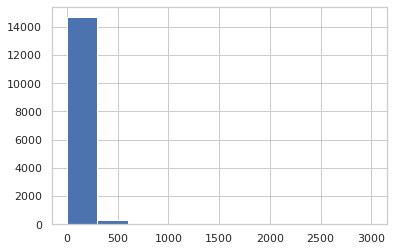

In [34]:
plt.hist(df.loc[:,'Fee'])

As can be seen from the plot above, >14k samples have a value of 0. As such this attribute won't contribute much to training, instead might make it worse. It is similar to having a sparse vector as training data. 
Given, the distribution there is no point in scaling the values and keeping it for training (scaling to a smaller range, say 1-10, would only make most of the non-zero values close to 0). Hence, it is better to remove this attribute although semantically it might seem to be an important attribute

In [35]:
df = df.drop(['Fee'], axis=1)
print('Current Dataframe - ', df.shape)

Current Dataframe -  (14993, 16)


#### FEATURE ENGINEERING IMAGE DATA

In [36]:
from skimage.color import gray2rgb
from skimage.transform import resize

mean = [0.485,0.456,0.406] # standard values, based on ImageNet data
std = [0.229,0.224,0.225] # standard values, based on ImageNet data

def read_image(path):
    """
    resizing image into size 224x224x3 to feed into ResNet50
    """
    default_path = '../input/petfinder-adoption-prediction/train_images/86e1089a3-1.jpg'
    try:
        img = image.imread(path)
        img = img/255.0
        
    except FileNotFoundError:
        img = image.imread(default_path) #read this default img (randomly selected to fill missing data)
        img = img/255.0
    
    return gray2rgb(resize(img, (160,160)))

def normalize_image(img):
    
    img[:,:,0] -= mean[0]
    img[:,:,0] /= std[0]
        
    img[:,:,1] -= mean[1]
    img[:,:,1] /= std[1]
        
    img[:,:,2] -= mean[2]
    img[:,:,2] /= std[2]
        
    return img

# 4. Data Preparation

Preparing the data in the right format to feed into the neural network model. Utility functions to help during training, plotting,..

In [37]:
from sklearn.model_selection import train_test_split

# seperate the target and features
target = df.loc[:, 'AdoptionSpeed'].to_numpy()
features = df.drop(['AdoptionSpeed'], axis=1).to_numpy()

train_x, val_x, train_y, val_y = train_test_split(features, target, test_size=0.10, random_state=42)

In [38]:
# remove the image col from the numpy arrays (index 12 in a row)
train_images = train_x[:, 12]
val_images = val_x[:,12]
train_x = np.delete(train_x, 12, 1)
val_x = np.delete(val_x, 12, 1)

In [39]:
# One Hot Encoding the labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train = enc.fit_transform(train_y.reshape(-1,1))
y_val = enc.fit_transform(val_y.reshape(-1,1))

In [40]:
print('Train X - ', train_x.shape, '\nVal X - ', val_x.shape, '\nTrain Y - ', y_train.shape, '\nVal Y - '
     , y_val.shape, '\nTrain images - ', train_images.shape, '\nVal images - ', val_images.shape)

Train X -  (13493, 14) 
Val X -  (1500, 14) 
Train Y -  (13493, 5) 
Val Y -  (1500, 5) 
Train images -  (13493,) 
Val images -  (1500,)


In [41]:
# get the output of a neural network layer. Would be useful for data generator
def get_layer_output(model, data, layer = 'dense_4'):
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    prediction = feature_extraction_model.predict(np.asarray(data).astype(np.float32))
    #print(type(prediction))
    #print(prediction.shape)
    return np.asarray(prediction).astype(np.float32)

In [49]:
# Generator to read and preprocess data in batches for model training
class DataGenerator(Sequence) :
     
    def __init__(self, trainX, train_imgs, y_train, model, densenet, batch_size) :
        self.trainx = trainX
        self.imgs = train_imgs
        self.labels = y_train
        self.model_1 = model
        self.densenet = densenet
        self.batch_size = batch_size
    
    def __len__(self) :
        return (np.ceil(len(self.imgs) / float(self.batch_size))).astype(np.int)
  
    def __getitem__(self, idx) :
        batch_x_imgs = self.imgs[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x = self.trainx[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        NN_1_data = get_layer_output(self.model_1, batch_x)
        images = []
        for file in batch_x_imgs:
            images.append(normalize_image(read_image(img_path+file+'-1.jpg')))
        
        DenseNet_data = get_layer_output(self.densenet, np.array(images), layer='avg_pool')
        
        return np.concatenate((NN_1_data, DenseNet_data), axis=1), np.array(batch_y)

In [43]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# 5. Model Training

The proposed model is similar to the architecture shown in the figure below. The ordered data ('categorical data A' as per the figure) would be fed into the 1st neural network (NN-1) which would be trained on the actual targets. After NN-1 is trained, the output (Out-1) of a layer in NN-1 would be taken to prepare the input for 2nd neural network (NN-2). 
The image data would be fed into a pretrained convolutional neural network (say, ResNet50), and the output of last hidden layer would be extracted (Out-2). This output combined with NN-1 output (Out-1 + Out-2) is then fed into NN-2 as input. NN-2 then outputs the class probabilities


Fig credits - [[StackExchange](https://datascience.stackexchange.com/questions/29634/how-to-combine-categorical-and-continuous-input-features-for-neural-network-trai)]

![model](https://i.stack.imgur.com/QgQFq.png)

In [61]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Input, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD
from keras.applications import DenseNet169
from keras.models import load_model

#### NEURAL NETWORK MODEL 1 (PET ATTRIBUTES DATA)

In [56]:
# NN-1 model
inputs = Input(shape=(14,))
x = Dense(32, activation='sigmoid')(inputs)
#x = Dropout(0.2)(x)
x = Dense(64, activation='sigmoid')(x)
#x = Dense(128)(x) ## Deeper networks degrade the model. Doesn't fit the data well
#x = Dense(256, activation='tanh')(x)
#x = Dropout(0.25)(x)
#x = Dense(512, activation='sigmoid')(x)
#x = Dense(20, activation='tanh')(x)
#x = Dropout(0.25)(x)
out = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=out)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 2,917
Trainable params: 2,917
Non-trainable params: 0
_________________________________________________________________


In [57]:
# NN-1 model
lr = 0.001
checkpt = ModelCheckpoint(filepath='../input/output/models/best_model.h5',monitor='val_acc',save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy',metrics=['accuracy'])

In [49]:
# EXPERIMENTAL
# scaling down the name column of training data
def scaleData(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    return X_std * (10)
train_x[:,3] = scaleData(train_x[:, 3])
train_x[:,1] = scaleData(train_x[:, 1])

# After scaling, all values remain same, except training accuracy increases by 8%

In [58]:
# NN-1 model
history = model.fit(np.asarray(train_x).astype(np.float32),np.asarray(y_train),epochs=200,batch_size=32,shuffle=True,
          validation_data=(np.asarray(val_x).astype(np.float32),np.asarray(y_val)),callbacks=[checkpt])

Epoch 1/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4733 - accuracy: 0.2753 - val_loss: 1.4794 - val_accuracy: 0.2833
Epoch 2/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4685 - accuracy: 0.2781 - val_loss: 1.4751 - val_accuracy: 0.2673
Epoch 3/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4688 - accuracy: 0.2716 - val_loss: 1.4777 - val_accuracy: 0.2620
Epoch 4/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4673 - accuracy: 0.2707 - val_loss: 1.4735 - val_accuracy: 0.2640
Epoch 5/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4685 - accuracy: 0.2768 - val_loss: 1.4790 - val_accuracy: 0.2707
Epoch 6/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4671 - accuracy: 0.2749 - val_loss: 1.4724 - val_accuracy: 0.2880
Epoch 7/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4670 - accuracy: 0.2831 - val_loss: 1.4841 - val_accuracy: 0.2627

Epoch 58/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4647 - accuracy: 0.2796 - val_loss: 1.4752 - val_accuracy: 0.2620
Epoch 59/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4647 - accuracy: 0.2829 - val_loss: 1.4746 - val_accuracy: 0.2627
Epoch 60/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4651 - accuracy: 0.2788 - val_loss: 1.4731 - val_accuracy: 0.2620
Epoch 61/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4645 - accuracy: 0.2787 - val_loss: 1.4746 - val_accuracy: 0.2620
Epoch 62/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4647 - accuracy: 0.2804 - val_loss: 1.4730 - val_accuracy: 0.2620
Epoch 63/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4647 - accuracy: 0.2775 - val_loss: 1.4741 - val_accuracy: 0.2620
Epoch 64/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4643 - accuracy: 0.2808 - val_loss: 1.4720 - val_accuracy:

Epoch 115/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4635 - accuracy: 0.2819 - val_loss: 1.4736 - val_accuracy: 0.2627
Epoch 116/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4630 - accuracy: 0.2827 - val_loss: 1.4726 - val_accuracy: 0.2627
Epoch 117/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4634 - accuracy: 0.2820 - val_loss: 1.4724 - val_accuracy: 0.2647
Epoch 118/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4638 - accuracy: 0.2836 - val_loss: 1.4732 - val_accuracy: 0.2633
Epoch 119/200
422/422 [==============================] - 1s 1ms/step - loss: 1.4637 - accuracy: 0.2824 - val_loss: 1.4721 - val_accuracy: 0.2647
Epoch 120/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4634 - accuracy: 0.2839 - val_loss: 1.4737 - val_accuracy: 0.2633
Epoch 121/200
422/422 [==============================] - 1s 2ms/step - loss: 1.4635 - accuracy: 0.2805 - val_loss: 1.4740 - val_ac

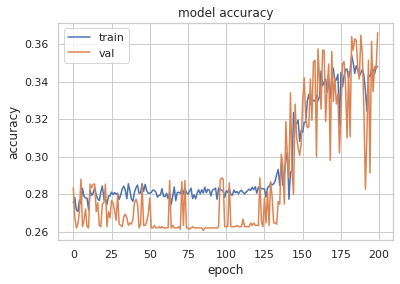

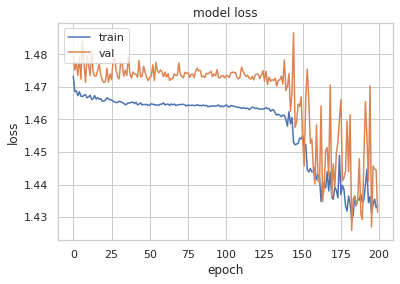

In [59]:
plot_history(history) #an averaged out curve might look less noisy

In [60]:
model.evaluate(np.array(val_x).astype(np.float32), np.array(y_val), batch_size=32)

47/47 [==============================] - 0s 1ms/step - loss: 1.4315 - accuracy: 0.3660


[1.4314589500427246, 0.3659999966621399]

In [46]:
model.save('best_model_latest.h5')
#model = load_model('../input/models-files/best_model_latest.h5')

#### NEURAL NETWORK MODEL 2 (COMBINES ATTRIBUTE DATA FEATURES AND IMAGE FEATURES)

In [47]:
# NN-2 model
model_densenet = DenseNet169(include_top=True, weights="imagenet")
model_densenet.summary()

58548224/58541896 [==============================] - 1s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

conv5_block13_0_relu (Activatio (None, 7, 7, 1024)   0           conv5_block13_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block13_1_conv (Conv2D)   (None, 7, 7, 128)    131072      conv5_block13_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block13_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block13_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block13_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block13_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block13_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block13_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [52]:
# NN-2 model
batch_size = 64

train_gen = DataGenerator(train_x, train_images, y_train, model, model_densenet, batch_size)
val_gen = DataGenerator(val_x, val_images, y_val, model, model_densenet,batch_size)

In [49]:
# NN-2 model
# Model architecture - input : (1728,)
inputs = Input(shape=(1728,))

x = Dense(1024, activation='sigmoid')(inputs)
x = Dropout(0.2)(x)

x = Dense(512, activation='sigmoid')(x)

x = Dense(256, activation='tanh')(x)
x = Dropout(0.25)(x)

x = Dense(256, activation='sigmoid')(x)

x = Dense(64, activation='tanh')(x)
x = Dropout(0.25)(x)

out = Dense(5, activation='softmax')(x)

model_2 = Model(inputs=inputs, outputs=out)
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1728)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1770496   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792 

In [50]:
# NN-2 model
lr = 0.001
checkpt = ModelCheckpoint(filepath='../input/output/models/best_model_Part2.h5',monitor='val_acc',save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model_2.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy',metrics=['accuracy'])

In [53]:
# NN-2 model
history = model_2.fit_generator(generator=train_gen,steps_per_epoch = int(13493 // batch_size),epochs = 20,
                   verbose = 1,validation_data = val_gen,validation_steps = int(1500 // batch_size))

Epoch 1/20
210/210 [==============================] - 1039s 5s/step - loss: 1.5117 - accuracy: 0.2716 - val_loss: 1.4443 - val_accuracy: 0.3363
Epoch 2/20
210/210 [==============================] - 1046s 5s/step - loss: 1.4376 - accuracy: 0.3328 - val_loss: 1.4188 - val_accuracy: 0.3492
Epoch 3/20
210/210 [==============================] - 1019s 5s/step - loss: 1.4164 - accuracy: 0.3514 - val_loss: 1.4082 - val_accuracy: 0.3750
Epoch 4/20
210/210 [==============================] - 1045s 5s/step - loss: 1.4036 - accuracy: 0.3638 - val_loss: 1.4163 - val_accuracy: 0.3458
Epoch 5/20
210/210 [==============================] - 1083s 5s/step - loss: 1.3874 - accuracy: 0.3728 - val_loss: 1.4031 - val_accuracy: 0.3764
Epoch 6/20
210/210 [==============================] - 1045s 5s/step - loss: 1.3762 - accuracy: 0.3808 - val_loss: 1.4196 - val_accuracy: 0.3791
Epoch 7/20
210/210 [==============================] - 1036s 5s/step - loss: 1.3729 - accuracy: 0.3848 - val_loss: 1.4494 - val_accuracy:

KeyboardInterrupt: 

In [54]:
model_2.save('final_model_latest.h5')

#### Note: Due to certain resource constraints (Memory error , Long training times + connectivity issues) the 1st model training was halted. The <br>model was saved and trained seperately for several days for fewer number of epochs (8 or 10) each time, on Kaggle. With no provision for saving<br> the cell output on a kaggle editable notebook, the model training output could not be present as part of this main notebook

# 6. Model Evaluation
 
The model performance is measured using classification metrics like classification report, confusion matrix

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

In [25]:
# load the trained model
model_2 = load_model('final_model_latest.h5')

In [29]:
# evaluate model
model_2.evaluate_generator(val_gen, 1500)

[0.8631196022033691, 0.6690383553504944]


In [13]:
y_pred = model_2.predict_generator(val_gen, 1500)
y_pred.shape

(1500, 5)


In [12]:
# Converting predictions into suitable format to feed into sklearn libraries
def process_predictions():
    prediction = []
    for i in range(len(y_pred)):
        t = np.zeros(5)
        t[np.argmax(y_pred[i])] = 1
        prediction.append(t)
    return np.array(prediction)

prediction = process_predictions()

In [8]:
# Classification Report
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.72      0.67      0.69       295
           2       0.58      0.57      0.58       399
           3       0.53      0.73      0.61       333
           4       0.91      0.80      0.85       431

   micro avg       0.67      0.67      0.67      1500
   macro avg       0.55      0.55      0.55      1500
weighted avg       0.68      0.67      0.67      1500
 samples avg       0.67      0.67      0.67      1500



#### As per the Classification Report, the trained model shows : <br>

1. Accuracy : 67% <br>
2. Recall : 67% <br>
3. F1-Score : 67% <br>

Considering only the sample averages. Class wise, the model has the highest accuracy, recall and F1-score for class 'Adoption Speed 4' as can be seen from the report. 

Given the complexity of the data, the performance of the model seems to be decent enough (especially with limited resources to experiment). The performance/scores can be increased even more, with better architecture, preprocessing and tuning

In [18]:
# Confusion Matrix
print(multilabel_confusion_matrix(y_val,prediction,labels=[0,1,2,3,4]))

[[[1458    0]
  [  42    0]]

 [[1130   75]
  [  98  197]]

 [[ 937  164]
  [ 170  229]]

 [[ 952  215]
  [  91  242]]

 [[1035   34]
  [  87  344]]]


#### TRYING OUT A DIFFERENT TECHNIQUE

Training different ML classifiers like Adaboost, GB classifiers and combining the predictions with the predictions of NN model. Only the ordered data has been fed into these classifier during training

However performances are nearly same, in fact, combining worsens the performance. This is just an experimental technique, and isn't fully correct, as combining 2 different predictions (from 2 different models) just by averaging isn't semantically correct. A better and more robust model/architecture would be to train only a ML classifier(like DT) on the ordered data, and a neural network on the image data. The labels in both the cases would be same. Although, combining the predictions,in this case, still seems to be an issue, but a suitable classifier, (i.e. according to the type of training data) would be trained for ordered and the unordered data

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
clf1 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf2 = GradientBoostingClassifier(min_samples_split = 8, random_state=0)

In [51]:
# transform One hot encoded data to labelled data (as in labelEncoded data)
def decode(y):
    ys = []
    for i in range(len(y)):
        ys.append(np.argmax(y[i]))
    return np.array(ys)
y_train = decode(y_train)
y_val = decode(y_val)
y_pred = decode(prediction) # NN model predictions

In [55]:
clf1.fit(train_x, y_train) # fit the classifier

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [35]:
clf2.fit(train_x, y_train) # fit the classifier

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=8,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [57]:
pred1 = clf1.predict(val_x) # AdaBoost predictions

In [48]:
pred2 = clf2.predict(val_x) # GB predictions

In [58]:
#combining both models' predictions
def combinePreds(pred, y_pred):
    pred_combined = []
    for i in range(len(pred)):
        if pred[i]==y_pred[i]:
            pred_combined.append(pred[i])
        else:
            pred_combined.append(int((pred[i]+y_pred[i])//2))
    
    return pred_combined

pred_combined1 = combinePreds(pred1, y_pred)
pred_combined2 = combinePreds(pred2, y_pred)

In [43]:
# GradientBoosting Classifier classification report 
print(classification_report(y_val, pred_combined2))

              precision    recall  f1-score   support

           0       1.00      0.12      0.21        42
           1       0.65      0.63      0.64       295
           2       0.41      0.55      0.47       399
           3       0.37      0.46      0.41       333
           4       0.90      0.55      0.68       431

    accuracy                           0.53      1500
   macro avg       0.67      0.46      0.48      1500
weighted avg       0.61      0.53      0.54      1500

